# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data

In [3]:
# link to data for analysis
url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_180630.txt'

# Challenges

## 1. Import data

In [4]:
df = pd.read_csv(url, nrows=2000)

In [5]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,00:00:00,REGULAR,6667150,2259901
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,04:00:00,REGULAR,6667173,2259909
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,08:00:00,REGULAR,6667189,2259938
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,12:00:00,REGULAR,6667305,2260006
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,16:00:00,REGULAR,6667534,2260066


## 2. Add datetime column

In [6]:
# add datetime column
df['DATETIME'] = pd.to_datetime(df['DATE'].astype(str) + ' ' + df['TIME'].astype(str))
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,00:00:00,REGULAR,6667150,2259901,2018-06-23 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,04:00:00,REGULAR,6667173,2259909,2018-06-23 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,08:00:00,REGULAR,6667189,2259938,2018-06-23 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,12:00:00,REGULAR,6667305,2260006,2018-06-23 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,16:00:00,REGULAR,6667534,2260066,2018-06-23 16:00:00


## 3. Daily entries per turnstile

In [7]:
# add turnstile id column
# unit and SCP combined is unique identifier for each turnstile
df['TNSTL'] = df['UNIT'] + ' ' + df['SCP']
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,TNSTL
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,00:00:00,REGULAR,6667150,2259901,2018-06-23 00:00:00,R051 02-00-00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,04:00:00,REGULAR,6667173,2259909,2018-06-23 04:00:00,R051 02-00-00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,08:00:00,REGULAR,6667189,2259938,2018-06-23 08:00:00,R051 02-00-00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,12:00:00,REGULAR,6667305,2260006,2018-06-23 12:00:00,R051 02-00-00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,16:00:00,REGULAR,6667534,2260066,2018-06-23 16:00:00,R051 02-00-00


In [53]:
def net_entry(entry):
    if len(entry) > 2:
        return(entry[0] - entry[1])
    else:
        return(entry[0])

In [33]:
test = pd.Series([23, 56, 78, 99, 123, 6, 18, 44])

In [42]:
test.agg(len)

8

In [26]:
df['ENTRIES'].agg(len)

2000

In [16]:
df['ENTRIES'].astype(float)

dtype('int64')

In [31]:
df['ENTRIES'].diff()

0         NaN
1        23.0
2        16.0
3       116.0
4       229.0
5       285.0
6       161.0
7        19.0
8        13.0
9        80.0
10      177.0
11      220.0
12       97.0
13       15.0
14       28.0
15      134.0
16      263.0
17      745.0
18      193.0
19        8.0
20       35.0
21      126.0
22      254.0
23      683.0
24      128.0
25       14.0
26       39.0
27      139.0
28      299.0
29      774.0
        ...  
1970     33.0
1971     70.0
1972    154.0
1973    281.0
1974    252.0
1975     64.0
1976     29.0
1977    128.0
1978    240.0
1979    578.0
1980    339.0
1981     50.0
1982     19.0
1983    124.0
1984    215.0
1985    574.0
1986    409.0
1987     72.0
1988     24.0
1989    124.0
1990    241.0
1991    626.0
1992    395.0
1993     54.0
1994     25.0
1995    145.0
1996    211.0
1997    565.0
1998    398.0
1999     70.0
Name: ENTRIES, Length: 2000, dtype: float64

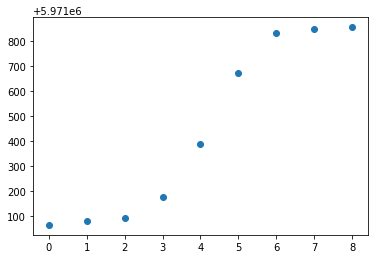

In [30]:
plt.scatter(range(9), df['ENTRIES'][41:50])

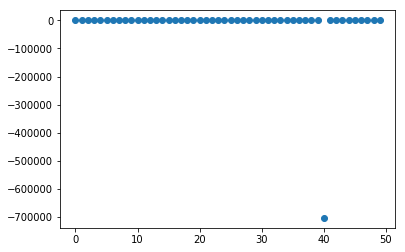

In [28]:
plt.scatter(range(50), df['ENTRIES'].diff().shift(-1)[0:50])

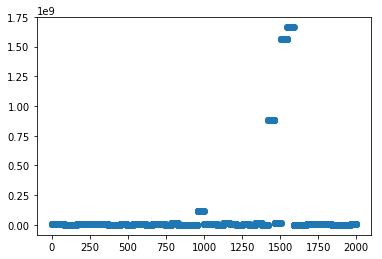

In [121]:
plt.scatter(range(len(df)), df['ENTRIES']);

In [56]:
# create new dataframe
df_tnstl = df.copy()
# take difference between adjacent rows in column then shift all values up one row
df_tnstl['ENTRIES'] = df_tnstl['ENTRIES'].diff().shift(-1)

In [108]:
# function to calculate entries between timestamps
def net_entries(entry):
    if entry < 0:
        return(0)
    else:
        return(entry)

In [116]:
df['ENTRIES'].diff().shift(-1).apply(net_entries)

0        23.0
1        16.0
2       116.0
3       229.0
4       285.0
5       161.0
6        19.0
7        13.0
8        80.0
9       177.0
10      220.0
11       97.0
12       15.0
13       28.0
14      134.0
15      263.0
16      745.0
17      193.0
18        8.0
19       35.0
20      126.0
21      254.0
22      683.0
23      128.0
24       14.0
25       39.0
26      139.0
27      299.0
28      774.0
29      216.0
        ...  
1970     70.0
1971    154.0
1972    281.0
1973    252.0
1974     64.0
1975     29.0
1976    128.0
1977    240.0
1978    578.0
1979    339.0
1980     50.0
1981     19.0
1982    124.0
1983    215.0
1984    574.0
1985    409.0
1986     72.0
1987     24.0
1988    124.0
1989    241.0
1990    626.0
1991    395.0
1992     54.0
1993     25.0
1994    145.0
1995    211.0
1996    565.0
1997    398.0
1998     70.0
1999      NaN
Name: ENTRIES, Length: 2000, dtype: float64

## 4. Daily entries plot

## 5. Daily entries for Control Area